In [ ]:
#install.packages(c("readr", "rpart", "rpart.plot", "survival", "survminer" , "ROCR" ,"e1071"))
library(readr)
library(rpart)
library(rpart.plot)
library(survival)
library(survminer)
library(lattice)
library(ggplot2)
library(caret)
library(ROCR)
library(e1071)



df <- read.csv("telco.csv")

# Data Cleaning/Manipulation

In [ ]:
# Drop the 'customerID' column
df <- subset(df, select = -customerID)

# Convert 'TotalCharges' to numeric
df$TotalCharges <- as.numeric(as.character(df$TotalCharges))

# Check for missing values - TotalCharges has 11
print(colSums(is.na(df)))

# Impute missing values in 'TotalCharges' with mean
df$TotalCharges[is.na(df$TotalCharges)] <- mean(df$TotalCharges, na.rm = TRUE)

# Drop rows where 'tenure' is 0
rows_with_tenure_0 <- which(df$tenure == 0)
df <- df[-rows_with_tenure_0, ]

# Convert 'SeniorCitizen' to categorical
df$SeniorCitizen <- factor(df$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))

# Create a list of categorical columns
cat_cols <- names(df)[sapply(df, is.factor)]
cat_cols <- cat_cols[cat_cols != "customerID"]  # Remove 'customerID' column

# Convert categorical variables to factors
df$gender <- as.factor(df$gender)
df[cat_cols] <- lapply(df[cat_cols], as.factor)

# Display summary statistics for 'InternetService'
print(summary(df$InternetService))

# Display summary statistics for numerical columns
numerical_cols <- c('tenure', 'MonthlyCharges', 'TotalCharges')
print(summary(df[, numerical_cols]))

# Convert 'Churn' to factor
df$Churn <- factor(df$Churn, levels = c("No", "Yes"))

          gender    SeniorCitizen          Partner       Dependents 
               0                0                0                0 
          tenure     PhoneService    MultipleLines  InternetService 
               0                0                0                0 
  OnlineSecurity     OnlineBackup DeviceProtection      TechSupport 
               0                0                0                0 
     StreamingTV  StreamingMovies         Contract PaperlessBilling 
               0                0                0                0 
   PaymentMethod   MonthlyCharges     TotalCharges            Churn 
               0                0               11                0 
   Length     Class      Mode 
     7032 character character 
     tenure      MonthlyCharges    TotalCharges   
 Min.   : 1.00   Min.   : 18.25   Min.   :  18.8  
 1st Qu.: 9.00   1st Qu.: 35.59   1st Qu.: 401.4  
 Median :29.00   Median : 70.35   Median :1397.5  
 Mean   :32.42   Mean   : 64.80   Mean   :22

# Kaplan-Meier Model on two cohorts of customers based on whether a customer has subscribed for Streaming TV or not.

In [ ]:
kmf <- survfit(Surv(tenure, Churn) ~ StreamingTV, data = df)
kmf

Call: survfit(formula = Surv(tenure, Churn) ~ StreamingTV, data = df)

                                         n nevent    rmean*
StreamingTV=No, (s0)                  2809      0 47.440355
StreamingTV=No internet service, (s0) 1520      0 66.459816
StreamingTV=Yes, (s0)                 2703      0 56.068951
StreamingTV=No, Yes                   2809    942 24.559645
StreamingTV=No internet service, Yes  1520    113  5.540184
StreamingTV=Yes, Yes                  2703    814 15.931049
   *restricted mean time in state (max time = 72 )

- n: number of observations in each group.
- nevent: churn observed in each group.
- rmean*: restricted mean time in state, which is the average time until churn occurs or the study ends.

Customers who are not subscribed to streaming TV or have no internet service have longer average times until churn compared to those who are subscribed to streaming TV or have internet service.

Customers who are subscribed to both streaming TV and internet service tend to have shorter average times until churn compared to other groups.


# Train - Test Split

In [ ]:
# Train - Test
set.seed(123)

# Split data, 75% distribution of churn for training
train.index <- createDataPartition( y = df$Churn, p = 0.75, list = FALSE)
train <- df[train.index,]
test <- df[-train.index,]

# Classification Tree Model

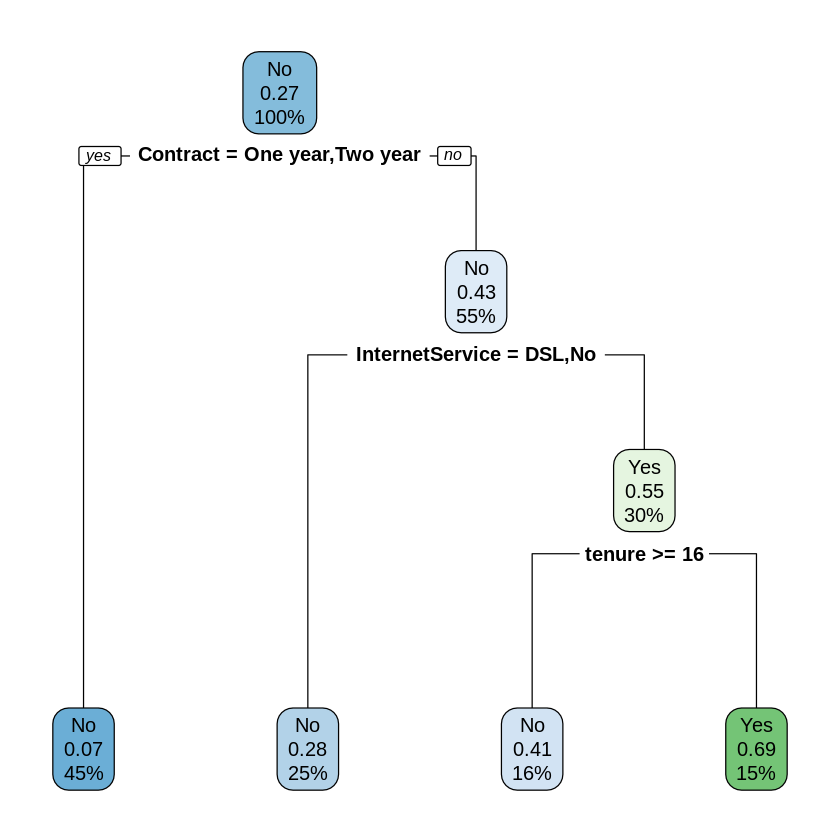

In [ ]:
tree_model <- rpart(Churn ~ ., data = df, method = "class")

# Visualize the tree
rpart.plot(tree_model)

In [ ]:
# Classification Tree - Confusion Matrix - Accuracy

# Prediction, classification  -  Classificatin Tree
tree.pred <- predict(tree_model,test, type = "class")
confusionMatrix(tree.pred,test$Churn)

# Prediction, probability
tree.pred.prob <- predict(tree_model, test, type = "prob")
tree.pred.prob.val <- prediction(tree.pred.prob[,2],test$Churn)
tree.pred.prob.perf <- performance(tree.pred.prob.val, "auc")

# print AUC value
paste("AUC Value is:", as.numeric(performance(tree.pred.prob.val, "auc")@y.values))
# plots the ROC curve with colors where the splits are.
plot(performance(tree.pred.prob.val, "tpr", "fpr"), colorize = TRUE ,main = "ROC Curve - Classification Tree")

# Random Forest

In [ ]:
#Random Forest

rf.fit  <- train(Churn ~ . , method = "rf", data = train, importance = TRUE)
rf.pred <- predict(rf.fit, test)
confusionMatrix(rf.pred, test$Churn)
#performance(rf.pred, measure = "auc")@y.values[[1]]

# Prediction, probability
rf.pred.prob <- predict(rf.fit, test, type = "prob")
rf.pred.prob.val <- prediction(rf.pred.prob[,2],test$Churn)
rf.pred.prob.perf <- performance(rf.pred.prob.val,"auc")

# print AUC value - Random Forest Model
paste("AUC Value is:", as.numeric(performance(rf.pred.prob.val, "auc")@y.values))
# plots the ROC curve with colors where the splits are.
plot(performance(rf.pred.prob.val, "tpr", "fpr"), colorize = TRUE , main = "ROC Curve - Random Forest")

# SVM

In [ ]:
model_svm <- svm(Churn~., train, kernel="linear", cost=0.1)
model_svm
predicted_svm<-predict(model_svm,test,decision.values = TRUE)
mean(predicted_svm==test$Churn)

svm_ct <- table(predicted_svm, test$Churn)
svm_ct
svm_recall <- svm_ct[2,2]/(svm_ct[2,2]+svm_ct[1,2])
svm_recall

## Linear Regression

In [ ]:
full.model <- glm(Churn ~., train, family = binomial)
summary(full.model)


step.model <- step(full.model, direction = "both", trace = FALSE)
summary(step.model)

#Confusion Matrix for step.model

predict.test <- predict(step.model, newdata = test, type = 'response')
predict.train <- predict(step.model, newdata = train, type = 'response')

# Convert predicted probabilities to class labels
predicted_classes_test <- ifelse(predict.test > 0.5, "Yes", "No")
predicted_classes_train <- ifelse(predict.train > 0.5, "Yes", "No")

# Get the actual class labels
true_labels_test <- test$Churn
true_labels_train <- train$Churn

# Compute the confusion matrix

confusion_matrix_test <- table(true_labels, predicted_classes_test)
print(paste("Confusion Matrix Test", confusion_matrix_test))

confusion_matrix_train <- table(true_labels_train, predicted_classes_train)
print(paste("Confusion Matrix Train", confusion_matrix_train))

# Accuracy of the model:
accuracy_test <- sum(predicted_classes_test == true_labels_test) / length(true_labels_test)
accuracy_train <- sum(predicted_classes_train == true_labels_train) / length(true_labels_train)

## KNN

In [ ]:
preProcValues <- preProcess(train, method = c("center", "scale"))
trainTransformed <- predict(preProcValues, train)
testTransformed <- predict(preProcValues, test)

In [ ]:
## K = 3
knn.churn3<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 3
)

predictions3 <- predict(knn.churn3, testTransformed,type = "class")

# Calculate confusion matrix
cm3 <- confusionMatrix(predictions3, testTransformed$Churn)
cm3

results3 <- data.frame(Accuracy = cm3$overall["Accuracy"],
           Sensitivity = cm3$byClass["Sensitivity"],
           Specificity = cm3$byClass["Specificity"])
results3$Accuracy


In [ ]:
knn.churn5<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 5
)

predictions5 <- predict(knn.churn5, testTransformed,type = "class")

# Calculate confusion matrix
cm5 <- confusionMatrix(predictions5, testTransformed$Churn)
cm5

results5 <- data.frame(Accuracy = cm5$overall["Accuracy"],
                       Sensitivity = cm5$byClass["Sensitivity"],
                       Specificity = cm5$byClass["Specificity"])
results5$Accuracy

In [ ]:
##KNN k = 9
knn.churn9<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 9
)

predictions9 <- predict(knn.churn9, testTransformed,type = "class")

# Calculate confusion matrix
cm9 <- confusionMatrix(predictions9, testTransformed$Churn)
cm9

results9 <- data.frame(Accuracy = cm9$overall["Accuracy"],
                       Sensitivity = cm9$byClass["Sensitivity"],
                       Specificity = cm9$byClass["Specificity"])
results9$Accuracy

In [ ]:
## KNN k = 11
knn.churn11<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 11
)

predictions11 <- predict(knn.churn11, testTransformed,type = "class")

# Calculate confusion matrix
cm11 <- confusionMatrix(predictions11, testTransformed$Churn)
cm11

results11 <- data.frame(Accuracy = cm11$overall["Accuracy"],
                       Sensitivity = cm11$byClass["Sensitivity"],
                       Specificity = cm11$byClass["Specificity"])
results11$Accuracy

In [ ]:
## KNN k = 13
knn.churn13<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 13
)

predictions13 <- predict(knn.churn13,
testTransformed,type = "class")
# Calculate confusion matrix
cm13 <- confusionMatrix(predictions13,testTransformed$Churn)
cm13

results13 <- data.frame(Accuracy = cm13$overall["Accuracy"],
                        Sensitivity = cm13$byClass["Sensitivity"],
                        Specificity = cm13$byClass["Specificity"])
results13$Accuracy

In [ ]:
## KNN k = 15
knn.churn15<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 15
)

predictions15 <- predict(knn.churn15, testTransformed,type = "class")

# Calculate confusion matrix
cm15 <- confusionMatrix(predictions15, testTransformed$Churn)
cm15

results15 <- data.frame(Accuracy = cm15$overall["Accuracy"],
                        Sensitivity = cm15$byClass["Sensitivity"],
                        Specificity = cm15$byClass["Specificity"])
results15$Accuracy

In [ ]:
## KNN k = 19
knn.churn19<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = 19
)

predictions19 <- predict(knn.churn19, testTransformed,type = "class")

# Calculate confusion matrix
cm19 <- confusionMatrix(predictions19, testTransformed$Churn)
cm19

results19 <- data.frame(Accuracy = cm19$overall["Accuracy"],
                        Sensitivity = cm19$byClass["Sensitivity"],
                        Specificity = cm19$byClass["Specificity"])
results19$Accuracy

In [ ]:
## Confirming K = 11 is best value
knnModel <- train(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  method = "knn",
  trControl = trainControl(method = "cv"),
  tuneGrid = data.frame(k = c(3,5,9,11,13,15,19))
)

best_model<- knn3(
  Churn ~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MonthlyCharges + TotalCharges,
  data = trainTransformed,
  k = knnModel$bestTune$k
)

accuracy.df <- data.frame(
  k_value = c(3,5,9,11,13,15,19),
  accuracy = c(results3$Accuracy,results5$Accuracy,results9$Accuracy, results11$Accuracy, results13$Accuracy, results15$Accuracy, results19$Accuracy)
)
accuracy.df

p <- ggplot(accuracy.df, aes(x = k_value, y = accuracy)) +
  geom_line(color = "lightgreen", linewidth = 2) +
  geom_point(color = "darkgreen", size = 5) +
  labs(title = "K-Nearest Neighbors Accuracy for Different K Values",
       x = "Number of Neighbors (K Value)",
       y = "Accuracy") +
  theme_minimal()

p + theme(plot.title = element_text(hjust = .5, face = 'bold'))